# Early Stopping Experiments for Logistic Regression

Reproducing Figure 1: GD on logistic regression with power-law covariance spectrum.

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.10.0+cu128
CUDA available: False


In [5]:
# ── Configuration ──────────────────────────────────────────────────────────

# Dimensions
d = 2000          # ambient dimension
n = 1000          # number of training samples

# True parameter
k_star = 100      # number of nonzero coordinates of w*
w_star_value = 1.0

# Covariance spectrum
USE_POWER_LAW_SPECTRUM = True   # True: lambda_i = i^{-a}, False: identity
spectrum_decay_rate = 2.0       # the 'a' parameter

# GD settings
eta = 0.5           # step size
num_iterations = 100_000

# Evaluation
n_test = 10_000     # test set size for Monte Carlo risk estimation

# Misc
device = "cuda" if torch.cuda.is_available() else "cpu"
seed = 42

print(f"Device: {device}")
print(f"d={d}, n={n}, k*={k_star}, a={spectrum_decay_rate}")

Device: cpu
d=2000, n=1000, k*=100, a=2.0


In [6]:
def generate_data(n, d, w_star, Sigma_sqrt, seed=None):
    """Generate data from the logistic model.

    X_i ~ N(0, Sigma), y_i ~ Bernoulli(sigmoid(x_i^T w*)) mapped to {+1, -1}.

    Sigma_sqrt is a 1D tensor (diagonal entries of Sigma^{1/2}).
    """
    if seed is not None:
        torch.manual_seed(seed)

    # z ~ N(0, I_d), then x = Sigma_sqrt * z (element-wise for diagonal)
    z = torch.randn(n, d, device=w_star.device)
    X = z * Sigma_sqrt.unsqueeze(0)  # (n, d)

    # Logistic probabilities
    logits = X @ w_star  # (n,)
    probs = torch.sigmoid(logits)

    # Sample labels in {+1, -1}
    y = 2.0 * torch.bernoulli(probs) - 1.0

    return X, y

In [7]:
def build_covariance_sqrt(d, use_power_law, decay_rate, device="cpu"):
    """Build the diagonal of Sigma^{1/2}.

    If power-law: Sigma = diag(i^{-a}), so Sigma^{1/2} = diag(i^{-a/2}).
    If identity: Sigma^{1/2} = I_d.
    """
    if use_power_law:
        indices = torch.arange(1, d + 1, dtype=torch.float64, device=device)
        Sigma_sqrt = indices.pow(-decay_rate / 2.0)
    else:
        Sigma_sqrt = torch.ones(d, dtype=torch.float64, device=device)
    return Sigma_sqrt

In [8]:
def build_w_star(d, k_star, w_star_value, device="cpu"):
    """Build the true parameter w*.

    First k_star coordinates = w_star_value, rest = 0.
    """
    w_star = torch.zeros(d, dtype=torch.float64, device=device)
    w_star[:k_star] = w_star_value
    return w_star

In [9]:
def logistic_loss(w, X, y):
    """Average logistic loss: (1/n) sum log(1 + exp(-y_i * x_i^T w))."""
    margins = y * (X @ w)
    # Numerically stable: log(1+exp(-m)) = max(-m,0) + log(1+exp(-|m|))
    loss = torch.nn.functional.softplus(-margins)
    return loss.mean().item()


def zero_one_error(w, X, y):
    """Classification error: fraction of sign(x^T w) != y."""
    preds = X @ w
    return (y * preds <= 0).float().mean().item()


def calibration_error(w, X, w_star):
    """Mean squared calibration error: E[(sigmoid(x^T w) - sigmoid(x^T w*))^2]."""
    p_w = torch.sigmoid(X @ w)
    p_star = torch.sigmoid(X @ w_star)
    return ((p_w - p_star) ** 2).mean().item()


def bayes_logistic_risk(X, y, w_star):
    """Logistic loss evaluated at the true w*."""
    return logistic_loss(w_star, X, y)


def bayes_zero_one_error(X, y, w_star):
    """Zero-one error at the true w*."""
    return zero_one_error(w_star, X, y)

In [10]:
def run_gd(X_train, y_train, eta, num_iters, X_test, y_test, w_star, log_every=100):
    """Run gradient descent on logistic loss, logging metrics.

    Gradient: -(1/n) X^T (y * sigmoid(-y * X w))
    """
    n, d = X_train.shape
    w = torch.zeros(d, dtype=X_train.dtype, device=X_train.device)

    history = {
        "iteration": [],
        "opt_length": [],        # eta * t
        "train_loss": [],
        "test_loss": [],
        "train_01_error": [],
        "test_01_error": [],
        "calibration_error": [],
        "w_norm": [],
    }

    # Precompute Bayes risks (constant across iterations)
    bayes_loss_test = bayes_logistic_risk(X_test, y_test, w_star)
    bayes_01_test = bayes_zero_one_error(X_test, y_test, w_star)
    history["bayes_loss_test"] = bayes_loss_test
    history["bayes_01_test"] = bayes_01_test

    def log_metrics(t):
        history["iteration"].append(t)
        history["opt_length"].append(eta * t)
        history["train_loss"].append(logistic_loss(w, X_train, y_train))
        history["test_loss"].append(logistic_loss(w, X_test, y_test))
        history["train_01_error"].append(zero_one_error(w, X_train, y_train))
        history["test_01_error"].append(zero_one_error(w, X_test, y_test))
        history["calibration_error"].append(calibration_error(w, X_test, w_star))
        history["w_norm"].append(torch.norm(w).item())

    # Log at t=0
    log_metrics(0)

    for t in range(1, num_iters + 1):
        # Compute gradient: -(1/n) X^T (y * sigmoid(-y * X @ w))
        margins = y_train * (X_train @ w)         # (n,)
        coeffs = y_train * torch.sigmoid(-margins) # (n,)
        grad = -(1.0 / n) * (X_train.t() @ coeffs) # (d,)

        w = w - eta * grad

        if t % log_every == 0 or t == num_iters:
            log_metrics(t)
            if t % (log_every * 100) == 0:
                print(f"  iter {t:>7d} | train loss {history['train_loss'][-1]:.4f} "
                      f"| test loss {history['test_loss'][-1]:.4f} "
                      f"| ||w|| {history['w_norm'][-1]:.2f}")

    return history

In [11]:
def run_l2_regularized(X_train, y_train, lambda_val, eta, num_iters):
    """GD on L_hat(w) + (lambda/2)||w||^2.

    Returns the final w.
    """
    n, d = X_train.shape
    w = torch.zeros(d, dtype=X_train.dtype, device=X_train.device)

    for t in range(1, num_iters + 1):
        margins = y_train * (X_train @ w)
        coeffs = y_train * torch.sigmoid(-margins)
        grad_logistic = -(1.0 / n) * (X_train.t() @ coeffs)
        grad = grad_logistic + lambda_val * w

        w = w - eta * grad

    return w

In [12]:
# ── Run Experiment ─────────────────────────────────────────────────────────

torch.manual_seed(seed)

# Build components
Sigma_sqrt = build_covariance_sqrt(d, USE_POWER_LAW_SPECTRUM, spectrum_decay_rate, device=device)
w_star = build_w_star(d, k_star, w_star_value, device=device)

# Generate data
X_train, y_train = generate_data(n, d, w_star, Sigma_sqrt, seed=seed)
X_test, y_test = generate_data(n_test, d, w_star, Sigma_sqrt, seed=seed + 1)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape},  y_test:  {y_test.shape}")
print(f"Label balance (train): {(y_train == 1).float().mean():.3f} positive")
print(f"Label balance (test):  {(y_test == 1).float().mean():.3f} positive")

# Run GD
print(f"\nRunning GD with eta={eta}, {num_iterations} iterations...")
history = run_gd(X_train, y_train, eta, num_iterations, X_test, y_test, w_star, log_every=100)

X_train: torch.Size([1000, 2000]), y_train: torch.Size([1000])
X_test:  torch.Size([10000, 2000]),  y_test:  torch.Size([10000])
Label balance (train): 0.493 positive
Label balance (test):  0.501 positive

Running GD with eta=0.5, 100000 iterations...
  iter   10000 | train loss 0.5155 | test loss 0.5889 | ||w|| 12.34
  iter   20000 | train loss 0.5034 | test loss 0.5938 | ||w|| 19.10
  iter   30000 | train loss 0.4941 | test loss 0.5974 | ||w|| 25.22
  iter   40000 | train loss 0.4862 | test loss 0.6004 | ||w|| 30.96
  iter   50000 | train loss 0.4792 | test loss 0.6032 | ||w|| 36.43
  iter   60000 | train loss 0.4728 | test loss 0.6057 | ||w|| 41.67
  iter   70000 | train loss 0.4669 | test loss 0.6081 | ||w|| 46.75
  iter   80000 | train loss 0.4613 | test loss 0.6104 | ||w|| 51.67
  iter   90000 | train loss 0.4561 | test loss 0.6126 | ||w|| 56.46
  iter  100000 | train loss 0.4512 | test loss 0.6147 | ||w|| 61.13


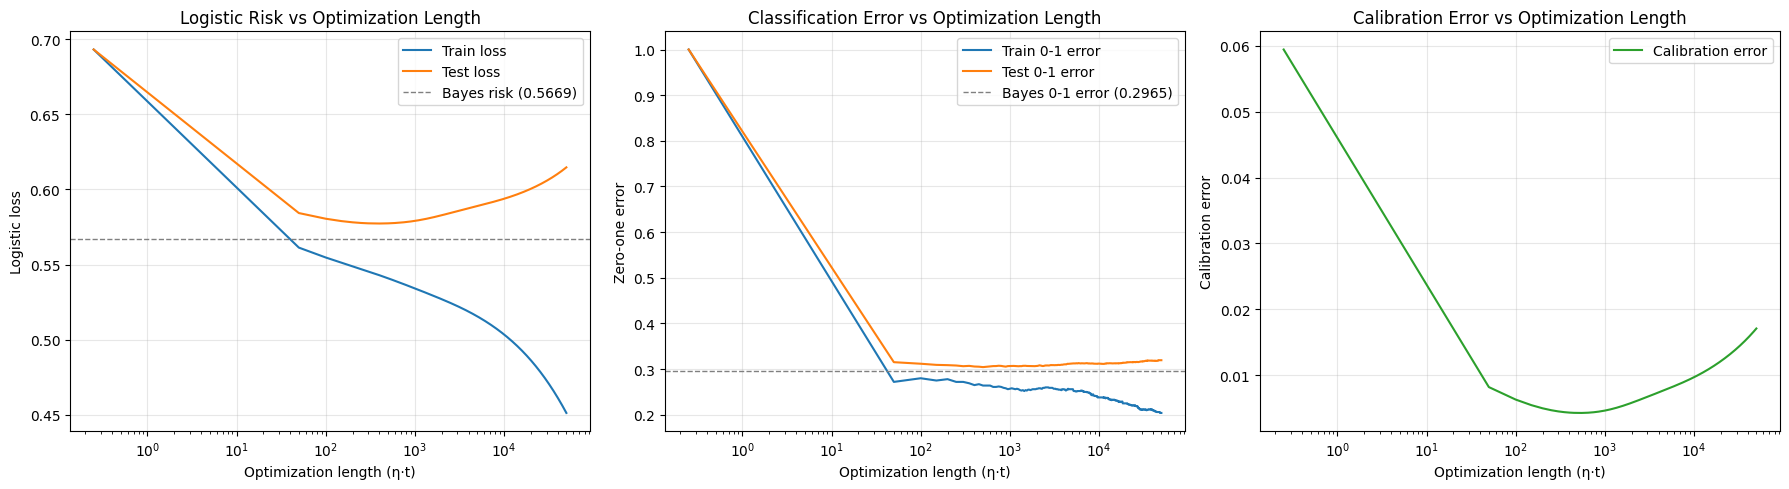


Best test logistic loss: 0.5773 at η·t = 400.0 (iter 800)
Best test 0-1 error:     0.3044 at η·t = 500.0 (iter 1000)
Bayes logistic risk:     0.5669
Bayes 0-1 error:         0.2965
Final train loss:        0.451195
Final test loss:         0.6147


In [13]:
# ── Visualization: Reproduce Figure 1 ─────────────────────────────────────

opt_length = np.array(history["opt_length"])
# Replace 0 with a small value for log scale
opt_length_plot = np.where(opt_length == 0, eta * 0.5, opt_length)

train_loss = np.array(history["train_loss"])
test_loss = np.array(history["test_loss"])
train_01 = np.array(history["train_01_error"])
test_01 = np.array(history["test_01_error"])
calib_err = np.array(history["calibration_error"])

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ── Panel 1: Logistic Risk ──
ax = axes[0]
ax.plot(opt_length_plot, train_loss, label="Train loss", linewidth=1.5)
ax.plot(opt_length_plot, test_loss, label="Test loss", linewidth=1.5)
ax.axhline(y=history["bayes_loss_test"], color="gray", linestyle="--",
           label=f"Bayes risk ({history['bayes_loss_test']:.4f})", linewidth=1)
ax.set_xscale("log")
ax.set_xlabel("Optimization length (η·t)")
ax.set_ylabel("Logistic loss")
ax.set_title("Logistic Risk vs Optimization Length")
ax.legend()
ax.grid(True, alpha=0.3)

# ── Panel 2: Zero-One Error ──
ax = axes[1]
ax.plot(opt_length_plot, train_01, label="Train 0-1 error", linewidth=1.5)
ax.plot(opt_length_plot, test_01, label="Test 0-1 error", linewidth=1.5)
ax.axhline(y=history["bayes_01_test"], color="gray", linestyle="--",
           label=f"Bayes 0-1 error ({history['bayes_01_test']:.4f})", linewidth=1)
ax.set_xscale("log")
ax.set_xlabel("Optimization length (η·t)")
ax.set_ylabel("Zero-one error")
ax.set_title("Classification Error vs Optimization Length")
ax.legend()
ax.grid(True, alpha=0.3)

# ── Panel 3: Calibration Error ──
ax = axes[2]
ax.plot(opt_length_plot, calib_err, label="Calibration error", linewidth=1.5, color="tab:green")
ax.set_xscale("log")
ax.set_xlabel("Optimization length (η·t)")
ax.set_ylabel("Calibration error")
ax.set_title("Calibration Error vs Optimization Length")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("figure1_reproduction.png", dpi=150, bbox_inches="tight")
plt.show()

# ── Summary statistics ──
best_test_idx = np.argmin(test_loss)
best_01_idx = np.argmin(test_01)
print(f"\nBest test logistic loss: {test_loss[best_test_idx]:.4f} "
      f"at η·t = {opt_length[best_test_idx]:.1f} (iter {history['iteration'][best_test_idx]})")
print(f"Best test 0-1 error:     {test_01[best_01_idx]:.4f} "
      f"at η·t = {opt_length[best_01_idx]:.1f} (iter {history['iteration'][best_01_idx]})")
print(f"Bayes logistic risk:     {history['bayes_loss_test']:.4f}")
print(f"Bayes 0-1 error:         {history['bayes_01_test']:.4f}")
print(f"Final train loss:        {train_loss[-1]:.6f}")
print(f"Final test loss:         {test_loss[-1]:.4f}")